# 04 - Applied ML

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import networkx as nx

import sklearn.model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

# Constants definition

In [2]:
DATA_PATH = "./data"

# Auxiliary functions

In [3]:
def plot_output_distributions(t, c):

    plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
    
    plt.hist(t['re78'], 30, color='blue', alpha=0.5, label='Treated distribution',
            range=(0,61000), cumulative=False)
    plt.hist(c['re78'], 30, color='green', alpha=0.5, label='Control distribution',
            range=(0,61000), cumulative=False)
    plt.legend(loc='best')
    plt.show()

In [4]:
def plot_feature_value_distributions(t, c):
    
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(15)
    fig.subplots_adjust(hspace=.5)
    
    fig.add_subplot(511)
    c['age'].plot(kind='hist', 
                  title='Age distribution of the observations', color='green', alpha=0.5)
    t['age'].plot(kind='hist', color='blue', alpha=0.5)
    l = plt.legend(loc='best')
    l.get_texts()[0].set_text('Control distribution')
    l.get_texts()[1].set_text('Treated distribution')

    
    fig.add_subplot(512)
    c['educ'].plot(kind='hist', 
                   title='Years of education distribution of the observations', color='green', alpha=0.5)
    t['educ'].plot(kind='hist', color='blue', alpha=0.5)
    l = plt.legend(loc='best')
    l.get_texts()[0].set_text('Control distribution')
    l.get_texts()[1].set_text('Treated distribution')

    
    fig.add_subplot(513)
    plt.hist([c['race'], t['race']], color=['green', 'blue'], alpha=0.5,
        label=['Control distribution', 'Treated distribution'] )
    plt.title('Ethinic distribution of the observations')
    plt.legend(loc='best')
    
    fig.add_subplot(514) 
    plt.hist( [c['married'], t['married']], color=['green', 'blue'], alpha=0.5,
        label=['Control distribution', 'Treated distribution'] )
    plt.title('Married distribution of the observations')
    plt.legend(loc='best')
   

    fig.add_subplot(515)
    plt.hist( [c['nodegree'], t['nodegree']], color=['green', 'blue'], alpha=0.5,
        label=['Control distribution', 'Treated distribution'] )
    plt.title('Subjects without a school degree distribution of the observations')
    plt.legend(loc='best')
    
    plt.show()

In [5]:
def build_graph(df):
    B = nx.Graph()
    
    # Add observations to the graph
    for i in df.index:
        if (df.get_value(i, 'treat') == 1):
            B.add_node(i, 
                       score = df.get_value(i, 'propensity score'), 
                       race = df.get_value(i, 'race'), 
                       married = df.get_value(i, 'married'),
                       nodegree = df.get_value(i, 'nodegree'),
                       educ = df.get_value(i, 'educ'),
                       age = df.get_value(i, 'age'),
                       bipartite = 0)
        else:
            B.add_node(i, 
                       score = df.get_value(i, 'propensity score'), 
                       race = df.get_value(i, 'race'), 
                       married = df.get_value(i, 'married'),
                       nodegree = df.get_value(i, 'nodegree'),
                       educ = df.get_value(i, 'educ'),
                       age = df.get_value(i, 'age'),
                       bipartite = 1)
            
    return B

 # 1 Propensity score matching

In [6]:
df = pd.read_csv("{}/lalonde.csv".format(DATA_PATH))
df.set_index('id', drop=True, inplace=True)

In [7]:
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [8]:
df['race'] = 0
df.loc[ df['black'] == 1, 'race' ] = 1
df.loc[ df['hispan'] == 1, 'race' ] = 2

df.drop(['black', 'hispan'], inplace=True, axis=1)

In [9]:
df.head()

,treat,age,educ,married,nodegree,re74,re75,re78,race
id,,,,,,,,,
NSW1,1,37,11,1,1,0.0,0.0,9930.0460,1
NSW2,1,22,9,0,1,0.0,0.0,3595.8940,2
NSW3,1,30,12,0,0,0.0,0.0,24909.4500,1
NSW4,1,27,11,0,1,0.0,0.0,7506.1460,1
NSW5,1,33,8,0,1,0.0,0.0,289.7899,1


### 1.1 A naive approach

In [10]:
treated = df[df["treat"] == 1]
control = df[df["treat"] == 0]

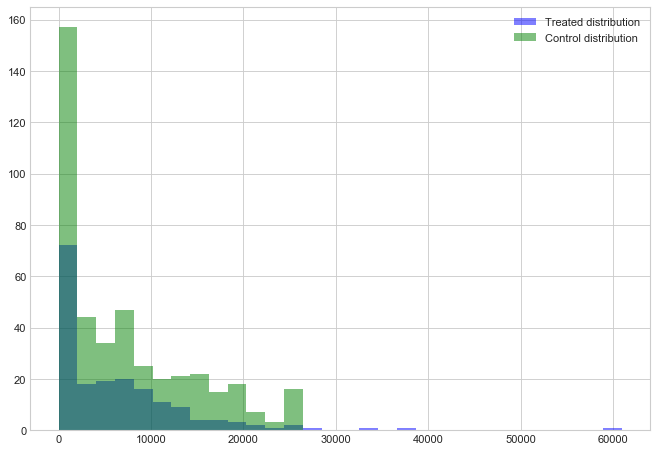

In [11]:
plot_output_distributions(treated, control)

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [12]:
stats.ks_2samp(treated['re78'],control['re78'])

Ks_2sampResult(statistic=0.098607698607698691, pvalue=0.15279452288468109)

### 1.2 A closer look at the data

We will get a closer look to the data by analyzing the covariates instead of stopping at the output as we did in the previous example. The covariates we will cover are:

In the following graph we will compare the distributions of thoe variables in the two groups, the treatment and the control.

/home/lucia/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


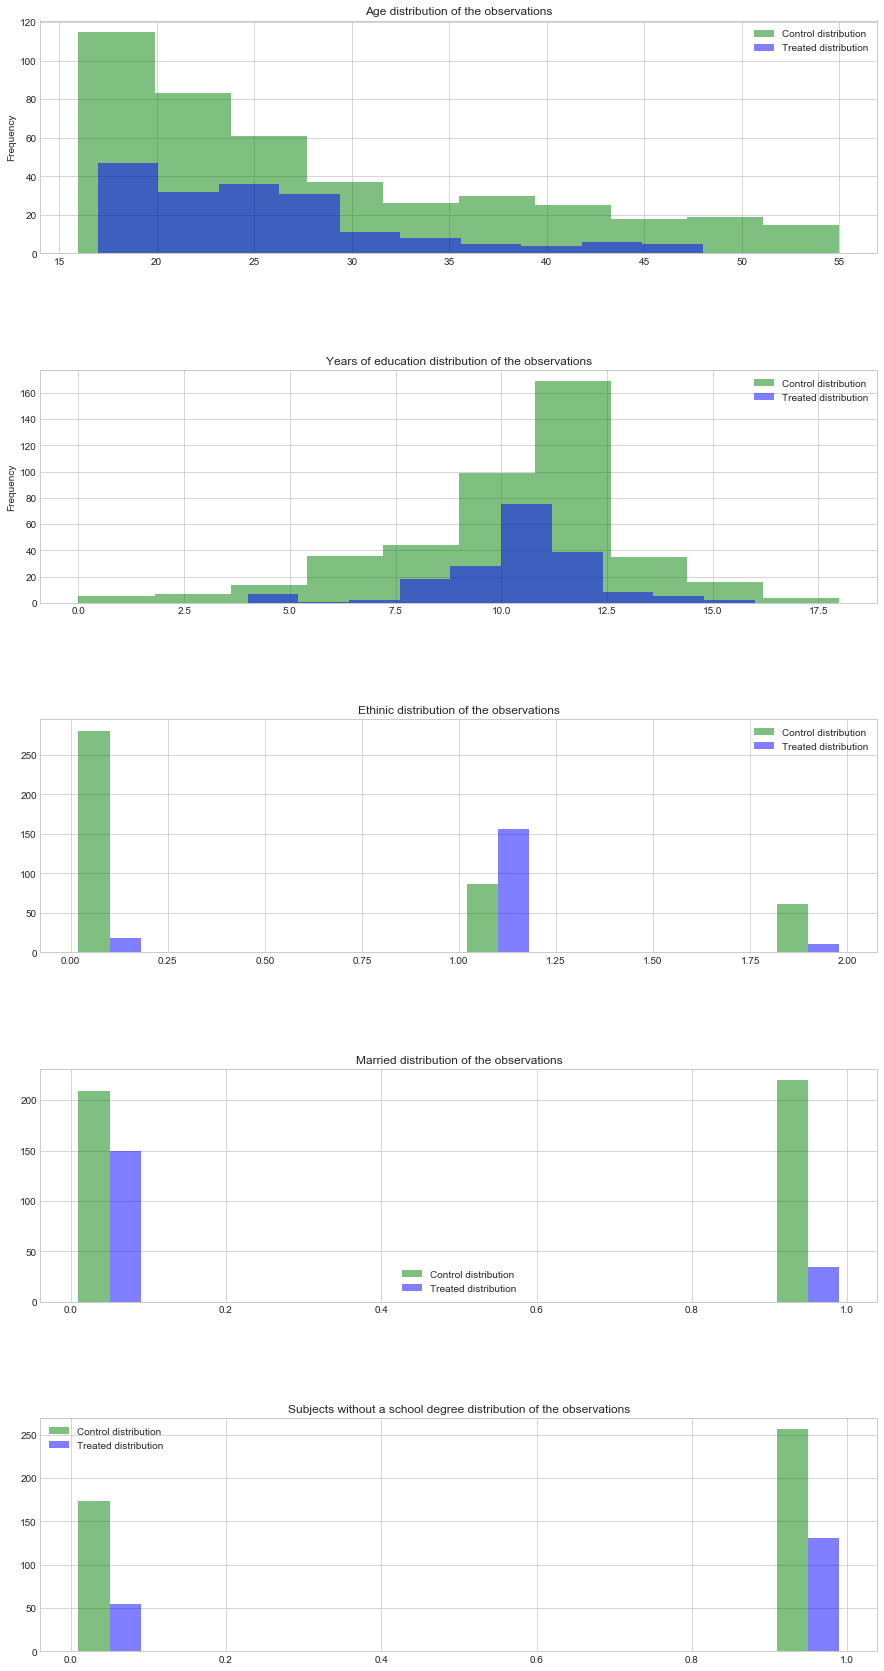

In [13]:
plot_feature_value_distributions(treated, control)

To make it more formal, we will compute again the K-S Test for the different distributions and compare them on that. The result is shown on a full dataframe

In [14]:
variables = ['age', 'educ', 'race', 'married', 'nodegree']
ks_test_df = pd.DataFrame(columns=['Variable', 'K-S Test statistics', 'K-S Test p-value'])

for v in variables:
    # compute the K-S Test statistic for the v-th variable
    ks = stats.ks_2samp(treated[v], control[v])
    
    # append the results tot he dataframe
    s = pd.Series([v, ks[0], ks[1]],index=['Variable','K-S Test statistics', 'K-S Test p-value'])
    ks_test_df = ks_test_df.append(s, ignore_index=True)
    
ks_test_df

,Variable,K-S Test statistics,K-S Test p-value
0,age,0.157727,2.778749e-03
1,educ,0.111372,7.524345e-02
2,race,0.557714,3.783551e-36
3,married,0.323631,1.871118e-12
4,nodegree,0.111372,7.524345e-02


Since the p-values are as shown in the dataset we can reject the null hypothesis (the distributions of the two samples are the same) since the pvalue is below 1%

### 1.3 A propensity score model

In the propensity score we want to obtain the probability to be under treatment according to the different covariates. In this case we will use the Logistic Regression Classifier to obtain a model for such task

In [15]:
logistic = LogisticRegression()

The differen covariates of this problem are the following:

In [16]:
features = ['age', 'educ', 'race', 'married', 'nodegree', 're74', 're75']

In [17]:
# The features vector
X = df[features]
X.head()

,age,educ,race,married,nodegree,re74,re75
id,,,,,,,
NSW1,37,11,1,1,1,0.0,0.0
NSW2,22,9,2,0,1,0.0,0.0
NSW3,30,12,1,0,0,0.0,0.0
NSW4,27,11,1,0,1,0.0,0.0
NSW5,33,8,1,0,1,0.0,0.0


We want to compute the probability of the treatment over the covariates. Our target will therefore be the treatment data

In [18]:
y = df['treat']

In [19]:
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
logistic.classes_

array([0, 1])

In [21]:
pred = logistic.predict_proba(X)
df['propensity score'] = pred[:, 1]
df.head()

,treat,age,educ,married,nodegree,re74,re75,re78,race,propensity score
id,,,,,,,,,,
NSW1,1,37,11,1,1,0.0,0.0,9930.0460,1,0.241581
NSW2,1,22,9,0,1,0.0,0.0,3595.8940,2,0.705622
NSW3,1,30,12,0,0,0.0,0.0,24909.4500,1,0.534734
NSW4,1,27,11,0,1,0.0,0.0,7506.1460,1,0.504228
NSW5,1,33,8,0,1,0.0,0.0,289.7899,1,0.519416


### 1.4 Balancing the dataset via matching

In [22]:
B = build_graph(df)

1 - abs (propensity(u) - propensity(v)) <-- you want the close scores, but with a 1- since we only have a maximum_match alo in this library

In [23]:
t_set = set(n for n,d in B.nodes(data=True) if d['bipartite']==0)
c_set = set(B) - t_set

In [24]:
B_weighted = nx.Graph()

for t_node in t_set:
    for c_node in c_set:
        weight = -100*abs(B.node[t_node]['score'] - B.node[c_node]['score'])
        B_weighted.add_edge(t_node, c_node, weight=weight)

In [25]:
nx.is_connected(B_weighted)

True

Compute the maximum of the different weights for the perfect matching on the scores

In [27]:
match = nx.max_weight_matching(B_weighted, maxcardinality=True)

In [28]:
matched_df = pd.DataFrame()

for e in match.items():
    s = df.loc[e[0], 'treat':'race']
    s.set_value('id', e[0])
    
    matched_df = matched_df.append(s, ignore_index=True)
    
matched_df.head()

,age,educ,id,married,nodegree,race,re74,re75,re78,treat
0,17.0,8.0,NSW61,0.0,1.0,1.0,0.0,0.0,0.000,1.0
1,17.0,8.0,PSID398,0.0,1.0,1.0,0.0,0.0,4520.366,0.0
2,20.0,12.0,NSW34,0.0,0.0,1.0,0.0,0.0,0.000,1.0
3,20.0,12.0,PSID373,0.0,0.0,1.0,0.0,0.0,0.000,0.0
4,19.0,11.0,NSW105,0.0,1.0,1.0,0.0,0.0,7458.105,1.0


In [29]:
matched_df_treated = matched_df[matched_df["treat"] == 1]
matched_df_control = matched_df[matched_df["treat"] == 0]

As we wanted, those two dataframes contain the same amount of treatment and control observations

In [30]:
print('Number of treatment observations {}'.format( len(matched_df_treated)))
print('Number of control observations {}'.format( len(matched_df_control)))

Number of treatment observations 185
Number of control observations 185


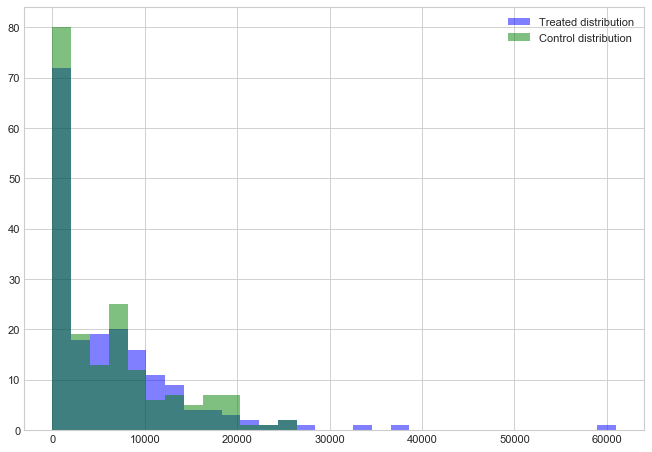

In [31]:
plot_output_distributions(matched_df_treated, matched_df_control)

K-S Test for the matched observations:

In [32]:
stats.ks_2samp(matched_df_treated['re78'],matched_df_control['re78'])

Ks_2sampResult(statistic=0.064864864864864868, pvalue=0.81873911619854023)

Compared to the previous result:

In [33]:
stats.ks_2samp(treated['re78'],control['re78'])

Ks_2sampResult(statistic=0.098607698607698691, pvalue=0.15279452288468109)

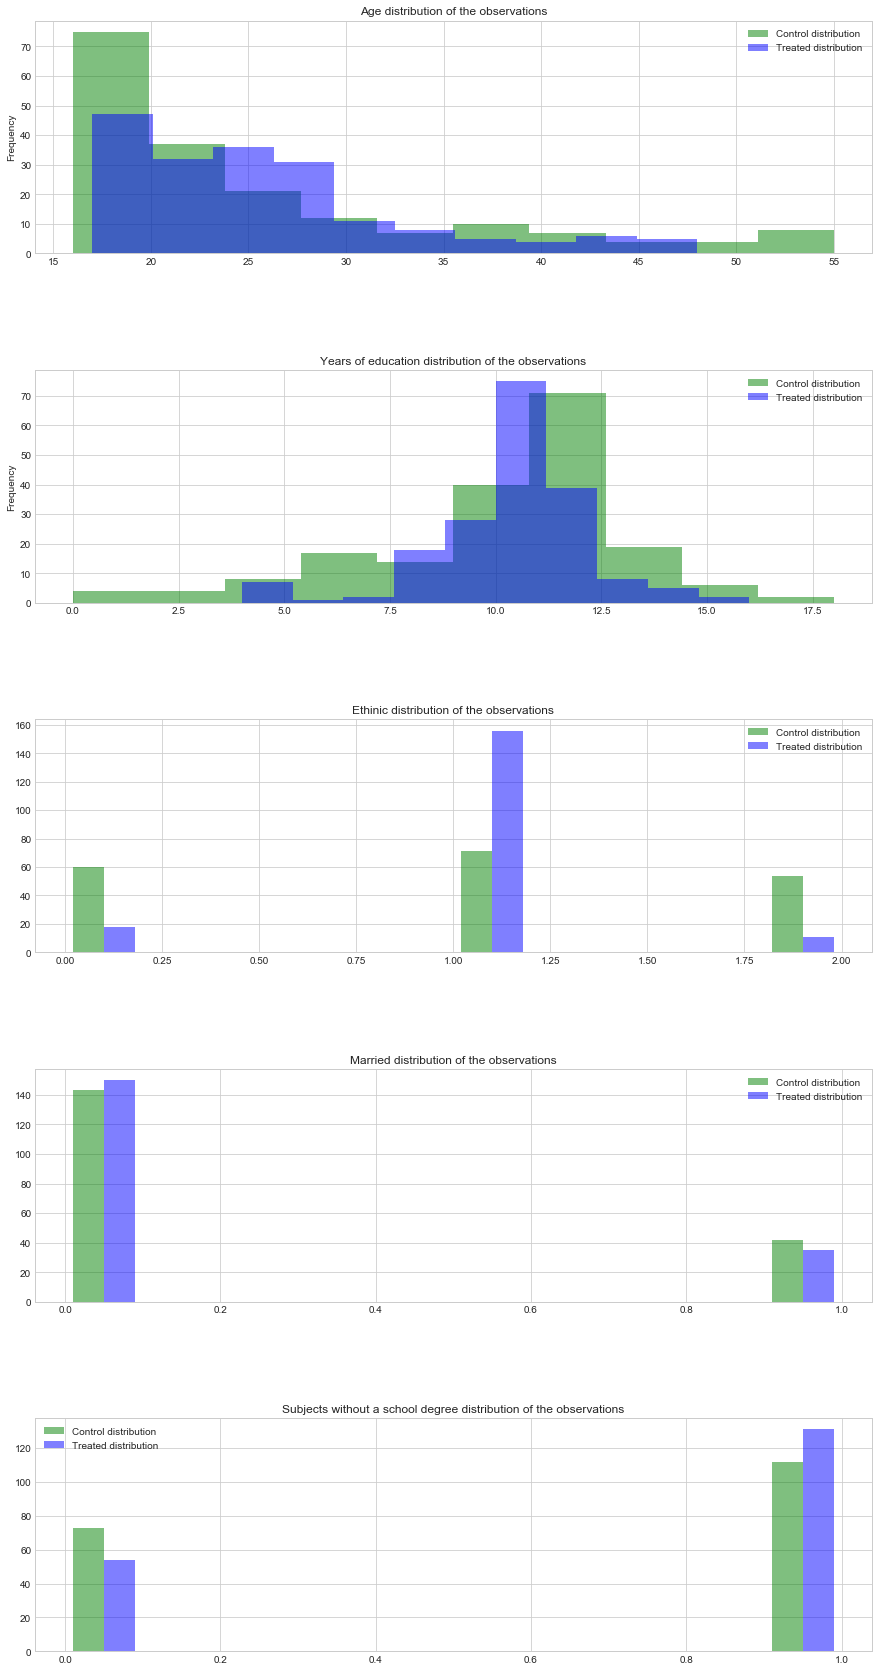

In [34]:
plot_feature_value_distributions(matched_df_treated, matched_df_control)

### 1.5 Balancing the groups further

From the previous part we have been able to match as close as possible both treatment and control observations. But we stil have some strong inbalances in the features that need to be analysed further. The balancing will take care of the two most problematic features: race and married.

In [36]:
B_improved = nx.Graph()

for t_node in t_set:
    for c_node in c_set:
        same_race = (B.node[t_node]['race'] == B.node[c_node]['race'])
        same_married = (B.node[t_node]['married'] == B.node[c_node]['married'])
        weight = 0
        if same_race:
            weight = -100*abs(B.node[t_node]['score'] - B.node[c_node]['score'])
            B_improved.add_edge(t_node, c_node, weight=weight)

In [37]:
match_improved = nx.max_weight_matching(B_improved, maxcardinality=True)

In [38]:
matched_improved_df = pd.DataFrame()

for e in match_improved.items():
    s = df.loc[e[0], 'treat':'race']
    s.set_value('id', e[0])
    
    matched_improved_df = matched_improved_df.append(s, ignore_index=True)
    
matched_improved_df.head()

,age,educ,id,married,nodegree,race,re74,re75,re78,treat
0,17.0,8.0,NSW61,0.0,1.0,1.0,0.0,0.0,0.000,1.0
1,17.0,8.0,PSID398,0.0,1.0,1.0,0.0,0.0,4520.366,0.0
2,20.0,12.0,NSW34,0.0,0.0,1.0,0.0,0.0,0.000,1.0
3,20.0,12.0,PSID373,0.0,0.0,1.0,0.0,0.0,0.000,0.0
4,19.0,11.0,NSW105,0.0,1.0,1.0,0.0,0.0,7458.105,1.0


In [39]:
matched_improved_df_treated = matched_improved_df[matched_improved_df["treat"] == 1]
matched_improved_df_control = matched_improved_df[matched_improved_df["treat"] == 0]

In [40]:
print('Number of treatment observations {}'.format( len(matched_improved_df_treated)))
print('Number of control observations {}'.format( len(matched_improved_df_control)))

Number of treatment observations 116
Number of control observations 116


In [41]:
B_weighted.edges['NSW87', 'PSID262']

{'weight': -59.347782987668552}

By the following plot we can see a better balance between the two groups for the different features

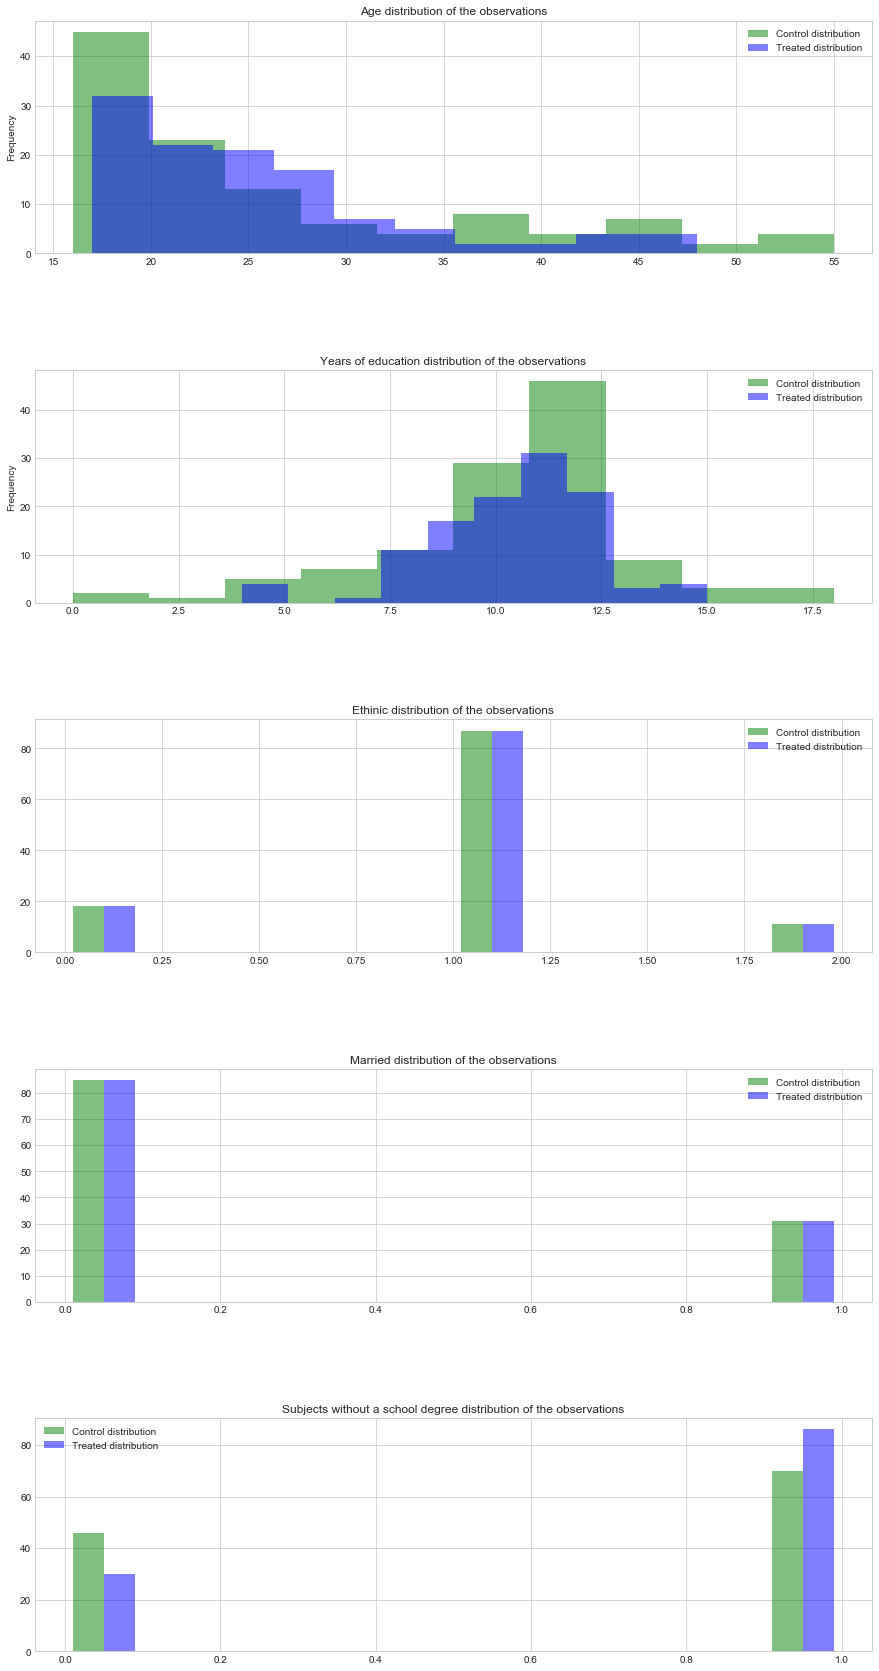

In [42]:
plot_feature_value_distributions(matched_improved_df_treated, matched_improved_df_control)

### 1.6 A less naive analysis

Eventually, we can check the output variable as did in the very first point of this question

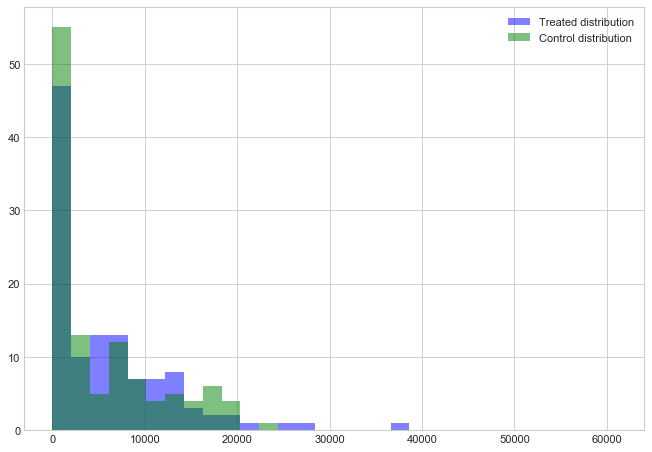

In [43]:
plot_output_distributions(matched_improved_df_treated, matched_improved_df_control)

In [44]:
stats.ks_2samp(matched_df_treated['re78'],matched_df_control['re78'])

Ks_2sampResult(statistic=0.064864864864864868, pvalue=0.81873911619854023)

 # Question 2: Applied ML

### 1)

In [ ]:
newsgroups = fetch_20newsgroups(data_home='{}/'.format(DATA_PATH) ,subset='all')

In [ ]:
print(newsgroups.data[1], end="\n\n")

In [ ]:
type(newsgroups)

In [ ]:
newsgroups.target_names

In [ ]:
tf = TfidfVectorizer(newsgroups.data)
tfidf_matrix = tf.fit_transform(newsgroups.data)
feature_names = tf.get_feature_names()

In [ ]:
tfidf_matrix.shape

In [ ]:
feature_names[100:120]

In [ ]:
rs = ShuffleSplit(n_splits=1, train_size=0.8, test_size=0.1)
rs.get_n_splits(newsgroups)

In [ ]:
for train_index, test_index in rs.split(newsgroups):

### 2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

In [ ]:
newsgroups_test = fetch_20newsgroups(data_home='{}/'.format(DATA_PATH) ,subset='test')
vectors_test = vectorizer.transform(newsgroups_train.data)

clf.fit(vectors, newsgroups_train.target)
pred = clf.predict(vectors_test)

metrics.f1_score(newsgroups_test.target, pred, average='macro')